# 90° Optical Hybrid

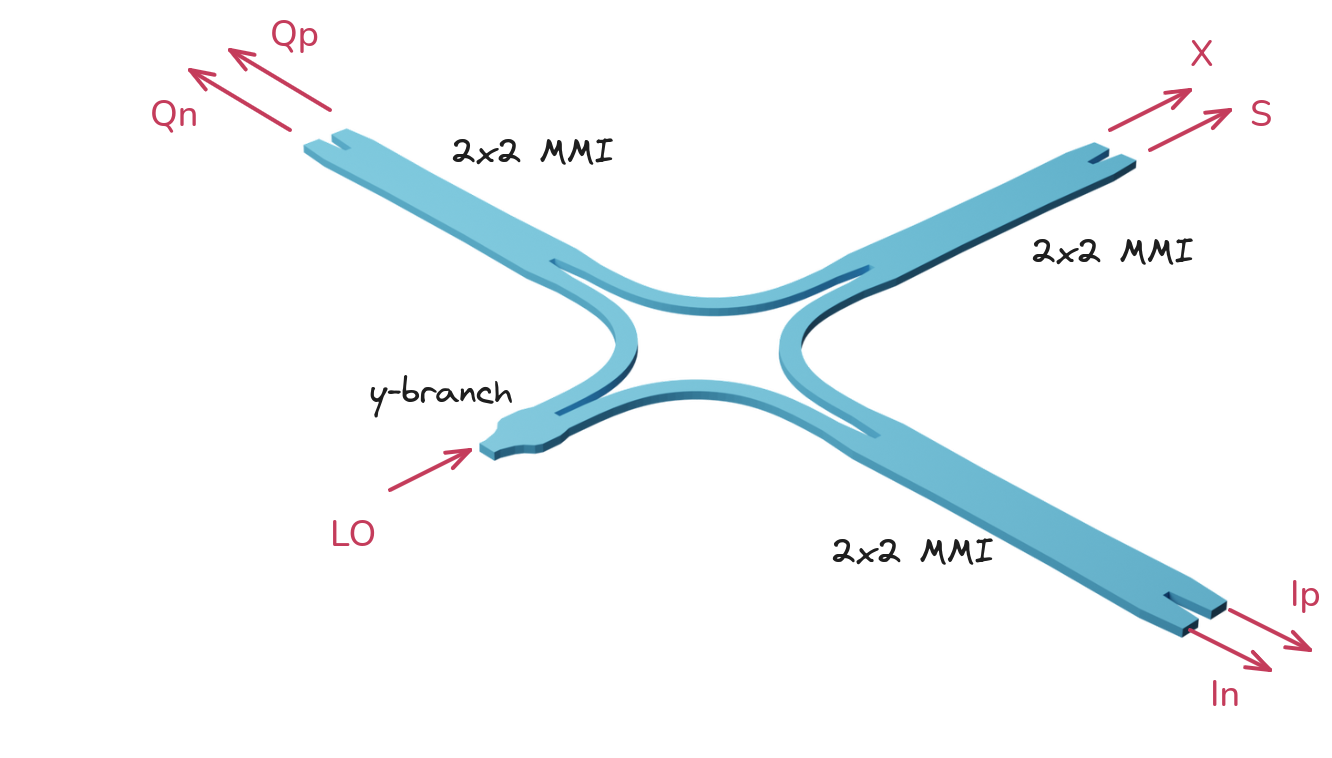

In this example we construct a 90° optical hybrid based on \[1].
The optical hybrid is a key component for mixing a reference to the incoming signal in a coherent detector to split its 4 quadrature states.
This hybrid is built from a [Y splitter](Y_Splitter.rst) \[2] and 3 2×2 multimode interferometers (MMI).

We first use an analytical model to show the ideal figures of merit of the design taking only the bend losses into account.
Then, we use FDTD models for each sub-component to obtain the full hybrid response, showing the effects of the real MMI and Y splitter in the design.
Finally, just for comparison, we simulate the full device in a single FDTD run, to show that both results match.

**References**

1. Hang Guan, Yangjin Ma, Ruizhi Shi, Xiaoliang Zhu, Rick Younce, Yaojia Chen, Jose Roman, Noam Ophir, Yang Liu, Ran Ding, Thomas Baehr-Jones, Keren Bergman, and Michael Hochberg, "Compact and low loss 90° optical hybrid on a silicon-on-insulator platform," _Opt. Express_ **25**, 28957-28968 (2017), DOI: [10.1364/OE.25.028957](https://doi.org/10.1364/OE.25.028957)

This example has an equivalent in the Tidy3D documentation: [90° optical hybrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/90OpticalHybrid.html).


In [1]:
import numpy as np
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d.plugins.mode.web import run as run_mode_solver

We will use the C band and PhotonForge's [basic_technology](../_autosummary/photonforge.basic_technology.rst) for this design.
The default silicon thickness and strip waveguide width matches our reference, so we can use all default parameters.

In [2]:
wavelengths = np.linspace(1.530, 1.565, 36)
tech = pf.basic_technology()

pf.config.default_technology = tech

In [3]:
port_spec = tech.ports["Strip"]
core_layer = "WG_CORE"
clad_layer = "WG_CLAD"

clad_width, _ = port_spec.path_profile_for(clad_layer)
core_width, _ = port_spec.path_profile_for(core_layer)
clad_margin = (clad_width - core_width) / 2

Both MMI and Y splitter, as proposed in \[1], have waveguide ports placed quite near each other (they are, in fact, coupled, as we can see in the [Y Splitter](Y_Splitter.rst) example).
Instead of adding extensions separating the ports, which would change the original design, we can check if the strip [port specification](../_autosummary/photonforge.PortSpec.rst) will work with a reduced dimension and provide us with a reasonable mode profile.
We do that by directly modifying the specification and solving for its modes using a Tidy3D mode solver:

19:55:54 -03 Mode solver created with                                           
             task_id='fdve-9a026a3c-2c49-417e-959d-dadacf539ea6',               
             solver_id='mo-8fc49cf5-659e-4001-977e-e061d2356093'.

Output()

Output()

19:55:59 -03 Mode solver status: queued

19:56:37 -03 Mode solver status: running

19:56:46 -03 Mode solver status: success

Output()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.915607e+14 0                1.565  2.425642    0.0          0.983018   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.915607e+14 0                 0.766046         0.81745   0.196095

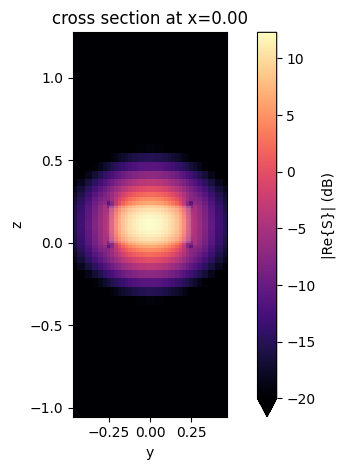

In [4]:
port_spec.width = 0.9

mode_solver = port_spec.to_tidy3d([pf.C_0 / wavelengths.max()])
run_mode_solver(mode_solver)

mode_solver.plot_field("S", mode_index=0, scale="dB", vmin=-20, robust=False)
mode_solver.data.to_dataframe()

We see that the mode intensity is approximately 30 dB lower at the simulation boundaries than at the core.
Although not ideal, we can use this profile to model our device and be able to connect individual ports.

## Subcomponents

We create the MMI shape based on the optimized values from \[1].
Besides the core region, we also add a cladding [envelope](../_autosummary/photonforge.envelope.rst) based on the strip port cladding margin, as used in the basic technology.
We add 2 models to the MMI: an analytical [directional coupler model](../_autosummary/photonforge.DirectionalCouplerModel.rst), which is very fast to compute and has an ideal S matrix response, and an [FDTD model](../_autosummary/photonforge.Tidy3DModel.rst) that allows us to get the simulated response of the device through Tidy3D.

In [5]:
def mmi_function():
    w = (1.48, 1.48, 1.6, 0.5, 0.7, 0.2)
    l = (1, 2.4, 1.6)
    vertices = np.array(
        (
            (-l[1] - l[2], w[5] / 2),
            (-l[0] - l[1] - l[2], (w[5] + w[4] - w[3]) / 2),
            (-l[0] - l[1] - l[2], (w[5] + w[4] + w[3]) / 2),
            (-l[1] - l[2], w[5] / 2 + w[4]),
            (-l[2], w[0] / 2),
            (0, w[1] / 2),
            (0, 0),
            (-l[1] - l[2], 0),
        )
    )
    core = pf.boolean(
        [
            pf.Polygon(vertices),
            pf.Polygon(-vertices),
            pf.Polygon(vertices * np.array((-1, 1))),
            pf.Polygon(vertices * np.array((1, -1))),
        ],
        [],
        "+",
    )[0]
    clad = pf.envelope(core, clad_margin, trim_x_min=True, trim_x_max=True)

    c = pf.Component("MMI")
    c.add(core_layer, core, clad_layer, clad)

    c.add_port(c.detect_ports([port_spec]))

    c.add_model(pf.DirectionalCouplerModel(), "Analytic")
    port_symmetries = [
        ("P0", "P1", {"P1": "P0", "P2": "P3", "P3": "P2"}),
        ("P0", "P2", {"P2": "P0", "P3": "P1", "P1": "P3"}),
        ("P0", "P3", {"P3": "P0", "P1": "P2", "P2": "P1"}),
    ]
    c.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries), "Tidy3D")

    return c


mmi = mmi_function()
mmi

The Y splitter follows a similar patter as the MMI: core defined by the reference, plus a cladding envelope.
However, the output ports of the Y splitter are originally adjacent to the wide face of the main splitter polygon.
That face will not correspond to the strip port index distribution, so we add a small waveguide section to the outputs to properly define the waveguides.
Note that, because we add the same section in both ports, there's no penalty for the overall design (except for the minimal extra loss from the waveguides themselves).

Again, we add 2 models to the component, an analytical [power splitter](../_autosummary/photonforge.PowerSplitterModel.rst) with ideal response, and an FDTD one.

In [6]:
def y_splitter_function():
    w = np.array((0.5, 0.5, 0.6, 0.7, 0.9, 1.26, 1.4, 1.4, 1.4, 1.4, 1.31, 1.2, 1.2))
    length = 2.0
    y_out = (w[-1] - core_width) / 2
    vertices = np.vstack((np.linspace(0, length, len(w)), -0.5 * w)).T
    y_shape = pf.Polygon(np.vstack((vertices, vertices[::-1] * np.array((1, -1)))))

    c = pf.Component("Y_SPLITTER")
    c.add(core_layer, y_shape)
    # We need 2 small sections to properly define the output waveguides, otherwise the numerical
    # mode solving will use the full Y shape at y == length as waveguide cross-section
    c.add(
        core_layer,
        pf.Path((length, y_out), w[0]).segment((0.1, 0), relative=True),
        pf.Path((length, -y_out), w[0]).segment((0.1, 0), relative=True),
    )
    c.add(clad_layer, pf.envelope(c, clad_margin, trim_x_min=True, trim_x_max=True))

    c.add_port(c.detect_ports([port_spec]))

    c.add_model(pf.PowerSplitterModel(), "Analytic")
    c.add_model(
        pf.Tidy3DModel(port_symmetries=[("P1", "P2", {"P0": "P0", "P2": "P1"})]),
        "Tidy3D",
    )

    return c


y_splitter = y_splitter_function()
y_splitter

For the bend, we use a [parametric component](../parametric.rst) available in PhotonForge with the radius specified in the main reference \[1], but with a partial Euler spiral curvature, to minimize losses.
Because the radius is small, we want to simulate the bend using a [Tidy3D model](../guides/Tidy3D_Model.ipynb) to see the effect of the losses in the final device.

In [7]:
bend = pf.parametric.bend(
    port_spec=port_spec,
    radius=4.0,
    angle=90,
    euler_fraction=0.5,
    name="BEND",
    active_model="Tidy3D",
)
bend

Starting...
Loading cached simulation from .tidy3d/pf_cache/DSH/fdtd_info-S2IWMUNZDH7OVWUY3EYB2JCWMDRCO2Y6QHFXE2QNNFWLPT4YPGJQ.json.
Progress: 100% 


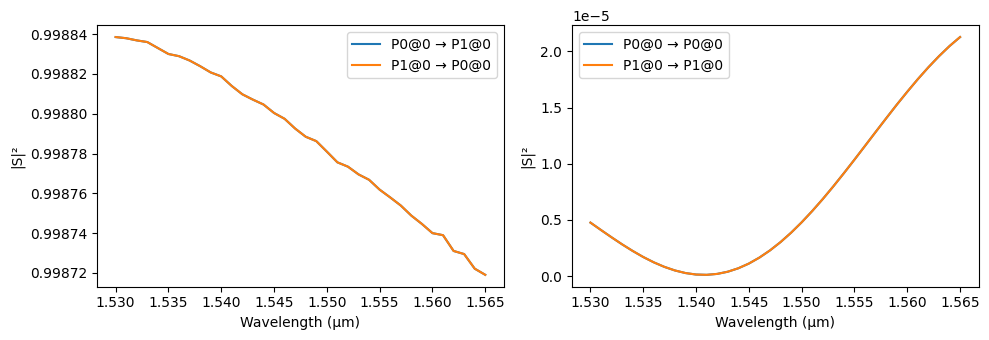

In [8]:
pf.Tidy3DModel.clear_cache()
_ = pf.plot_s_matrix(bend.s_matrix(pf.C_0 / wavelengths))

## Full Hybrid

The hybrid is simply composed of all previously defined components.
Because the distance between outputs in the Y splitter and MMI are different, we also need an extra waveguide section to fill in the gap that would otherwise appear.
After creating the component, we [export](../_autosummary/photonforge.Component.rst#photonforge.Component.write_gds) it to a GDSII that can be used elsewhere.

The hybrid uses a [circuit model](../_autosummary/photonforge.CircuitModel.rst) to connect all sub-components and use their S parameters to compute the global response.

In [9]:
def hybrid_function():
    m_gap = mmi.ports["P1"].center[1] - mmi.ports["P0"].center[1]
    y_gap = y_splitter.ports["P2"].center[1] - y_splitter.ports["P1"].center[1]
    fill = pf.parametric.straight(
        port_spec=port_spec,
        length=0.5 * (m_gap - y_gap),
        active_model="Waveguide",
        name="FILLER",
    )
    fill.active_model.verbose = False

    c = pf.Component("HYBRID")
    y0 = c.add_reference(y_splitter)
    ref = c.add_reference(bend).connect("P0", y0["P2"])
    ref = c.add_reference(fill).connect("P0", ref["P1"])
    m0 = c.add_reference(mmi).connect("P1", ref["P1"])
    ref = c.add_reference(bend).connect("P0", m0["P0"])
    m1 = c.add_reference(mmi).connect("P1", ref["P1"])
    ref = c.add_reference(bend).connect("P1", y0["P1"])
    ref = c.add_reference(fill).connect("P1", ref["P0"])
    m2 = c.add_reference(mmi).connect("P0", ref["P0"])
    ref = c.add_reference(bend).connect("P1", m2["P1"])

    c.add_port(y0["P0"], "LO")
    c.add_port(m0["P3"], "In")
    c.add_port(m0["P2"], "Ip")
    c.add_port(m2["P2"], "Qn")
    c.add_port(m2["P3"], "Qp")
    c.add_port(m1["P2"], "S")
    c.add_port(m1["P3"], "X")

    c.add_model(pf.CircuitModel(verbose=False), "Circuit")

    return c


hybrid = hybrid_function()
hybrid.write_gds()

We can first simulate the hybrid using the analytical models we created for the MMI and Y splitter.
The only non-ideal responses come from the bends, which are simulated using FDTD to include their curvature losses, and from the losses in the straight waveguide sections from their mode's complex effective index, as calculated previously.

Starting...


Progress: 100% 


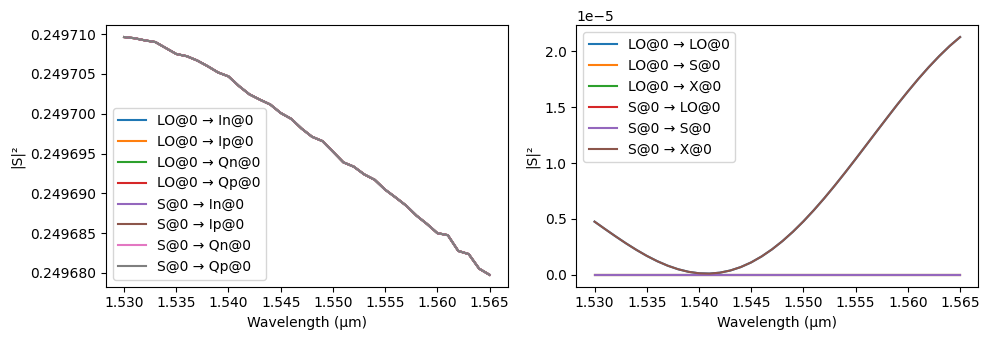

In [10]:
mmi.activate_model("Analytic")
y_splitter.activate_model("Analytic")

_ = pf.plot_s_matrix(hybrid.s_matrix(pf.C_0 / wavelengths), input_ports=["LO", "S"])

The figures of merit for the hybrid are defined as the insertion loss, phase error, common-mode rejection ratio, and the port imbalance, as defined in the reference.
We create an auxiliary plotting function to display those figures based on the computed S matrix:

In [11]:
def hybrid_plot(s):
    _, ax = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

    for port_in in ("LO", "S"):
        p_ip = np.abs(s[(f"{port_in}@0", "Ip@0")]) ** 2
        p_in = np.abs(s[(f"{port_in}@0", "In@0")]) ** 2
        p_qp = np.abs(s[(f"{port_in}@0", "Qp@0")]) ** 2
        p_qn = np.abs(s[(f"{port_in}@0", "Qn@0")]) ** 2

        loss = -10 * np.log10(p_ip + p_in + p_qp + p_qn)
        ax[0, 0].plot(wavelengths, loss, label=f"{port_in}")

        imbalance_i = 10 * np.log10(p_ip / p_in)
        imbalance_q = 10 * np.log10(p_qp / p_qn)
        ax[1, 1].plot(wavelengths, imbalance_i, label=f"I ({port_in})")
        ax[1, 1].plot(wavelengths, imbalance_q, label=f"Q ({port_in})")

        ratio = np.abs(p_ip - p_in) / (p_ip + p_in)
        ratio[ratio < 1e-15] = 1e-15  # avoid warnings in the log function
        cmrr_i = 20 * np.log10(ratio)

        ratio = np.abs(p_qp - p_qn) / (p_qp + p_qn)
        ratio[ratio < 1e-15] = 1e-15  # avoid warnings in the log function
        cmrr_q = 20 * np.log10(ratio)

        ax[1, 0].plot(wavelengths, cmrr_i, label=f"I ({port_in})")
        ax[1, 0].plot(wavelengths, cmrr_q, label=f"Q ({port_in})")

    φ1 = np.angle(s[("S@0", "Qp@0")], deg=True)
    φ2 = np.angle(s[("LO@0", "Qn@0")], deg=True)
    φ3 = np.angle(s[("LO@0", "In@0")], deg=True)
    φ4_θ = np.angle(s[("S@0", "Ip@0")], deg=True)

    phase_error = 90 - φ1 + φ2 - φ3 + φ4_θ
    ax[0, 1].plot(wavelengths, (phase_error + 180) % 360 - 180)

    ax[0, 0].legend()
    ax[0, 0].set(xlabel="Wavelength (µm)", ylabel="Insertion loss (dB)")
    ax[0, 1].set(xlabel="Wavelength (µm)", ylabel="Phase error (°)")
    ax[1, 0].legend()
    ax[1, 0].set(xlabel="Wavelength (µm)", ylabel="CMMR (LO input, dB)")
    ax[1, 1].legend()
    ax[1, 1].set(xlabel="Wavelength (µm)", ylabel="Imbalance (dB)")

Starting...


Progress: 100% 


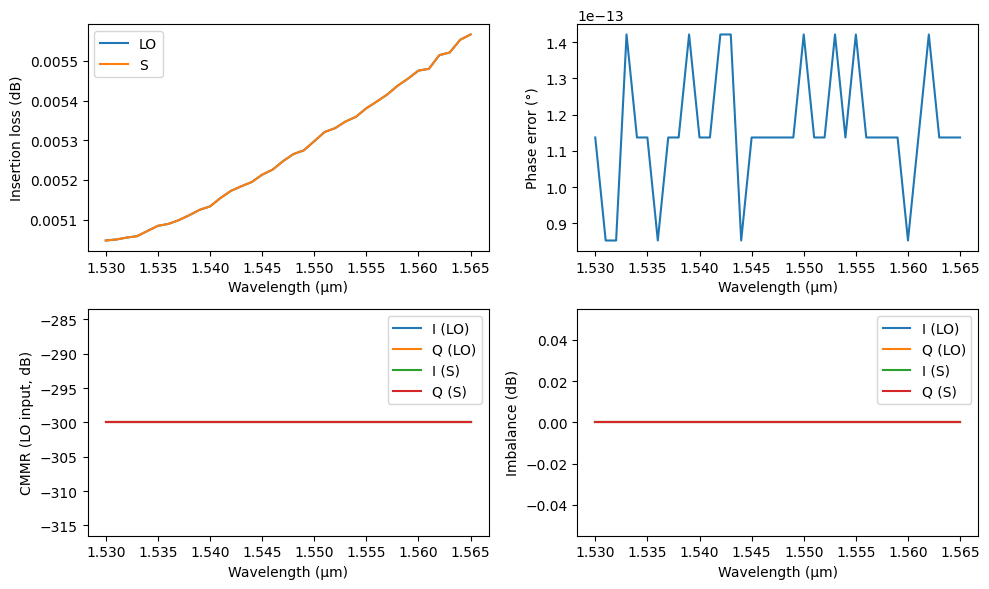

In [12]:
s_analytic = hybrid.s_matrix(pf.C_0 / wavelengths)
hybrid_plot(s_analytic)

As expected, being an analytic component, phase error, CMMR, and imbalance are zero (hence the runtime warnings), but we can already see the effects of the bend losses in the overall insertion loss to make adjustments to the radius, for example.
Now we can activate the full FDTD models to get a more accurate response.

Starting...
Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-QXH6BN4DMSHXXYZTFQWQMZWUSHUYKA5XAI4IMPUUMFNORH2M73YA.json.
Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-6N6LEYLF23YYI2IVERKILUL6TEU6KD5AJQZDG7DNGAFR2RK7UV7Q.json.


Loading cached simulation from .tidy3d/pf_cache/6UH/fdtd_info-BSNNUPTGQCR3HTNS6JPPJYM5DEOGWIABSOSS6I4FTTDBTL5SL3GQ.json.


Progress: 100% 


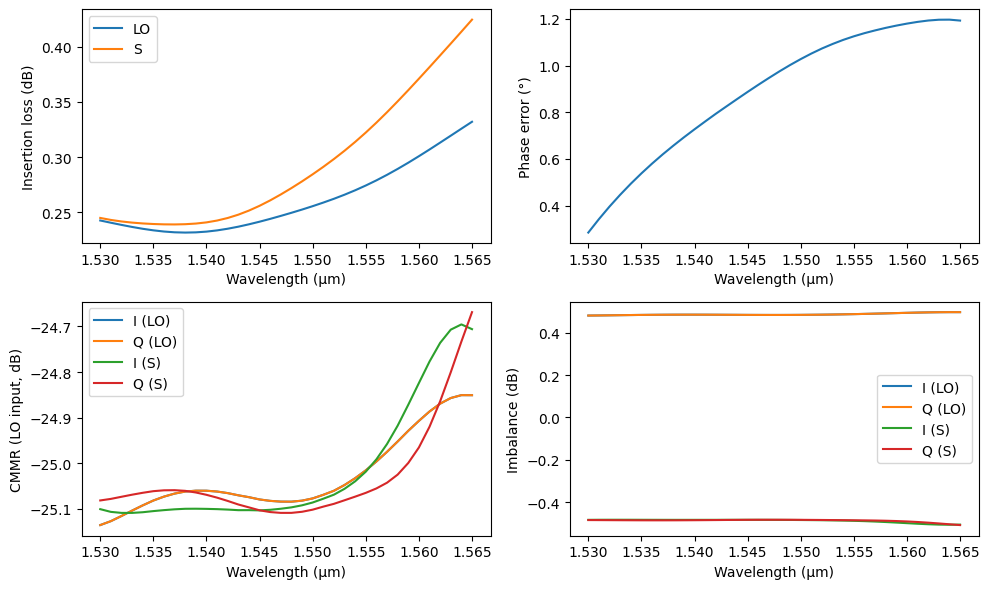

In [13]:
hybrid.activate_model("Circuit")
mmi.activate_model("Tidy3D")
y_splitter.activate_model("Tidy3D")

s_numeric = hybrid.s_matrix(pf.C_0 / wavelengths)
hybrid_plot(s_numeric)

Of course, after optimizing the design using the Circuit model, we can still verify the whole design using FDTD, seeing how Tidy3D can easily handle the scale of the complete device.
The differences we see come mostly from the bend modes not fully modeled by the straight waveguide ports, particularly when directly connected to MMI tapers.

Starting...
Loading cached simulation from .tidy3d/pf_cache/52S/fdtd_info-JUT3XNLZR7KHRHQVV2CHBTVYMEU7CPIPLKSK6MYOGKBONLHQPIEQ.json.


Loading cached simulation from .tidy3d/pf_cache/52S/fdtd_info-N6PYPEAK2DLDPG4IFGIORV32W4EVGLXHQTLKBE6Q2XWRNGNCG5LA.json.
Loading cached simulation from .tidy3d/pf_cache/52S/fdtd_info-H3KALJTL2CKVDNBSMH7FBJGBGFU54GOQSJXBRW47VXDAU2U4PWMA.json.
Loading cached simulation from .tidy3d/pf_cache/52S/fdtd_info-KEAXXOGAFTTYMMOOOAJC7LBEIAZH3E25RGLYMWEPZMNZC7EEN4VQ.json.
Progress: 100% 


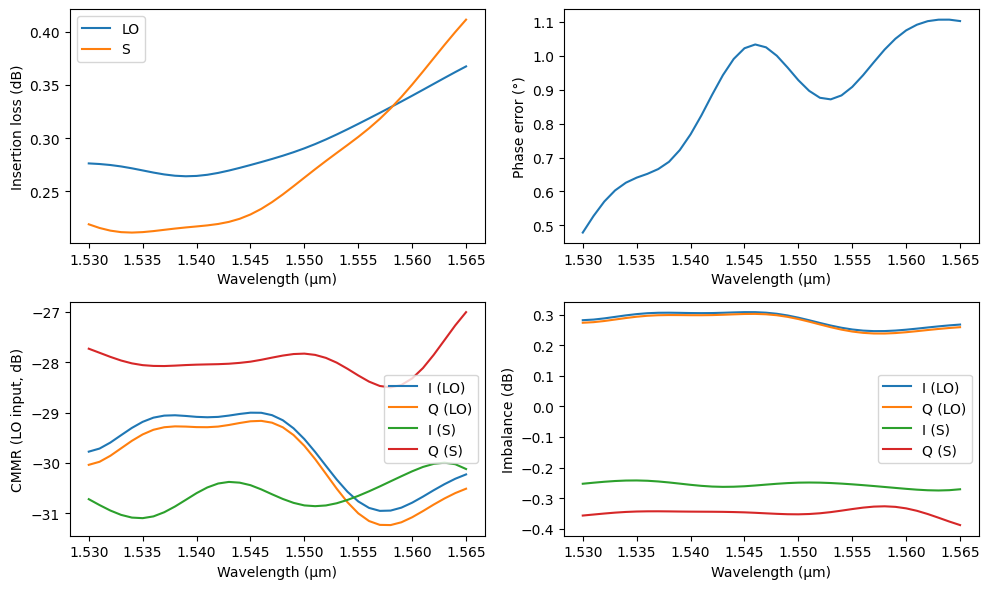

In [14]:
port_symmetries = [
    ("In", "Qn", {"LO": "LO", "Ip": "Qp", "Qn": "In", "Qp": "Ip", "S": "X", "X": "S"}),
    ("Ip", "Qp", {"LO": "LO", "In": "Qn", "Qn": "In", "Qp": "Ip", "S": "X", "X": "S"}),
    ("S", "X", {"LO": "LO", "In": "Qn", "Ip": "Qp", "Qn": "In", "Qp": "Ip", "X": "S"}),
]
hybrid.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries), "Tidy3D")

s_fdtd = hybrid.s_matrix(pf.C_0 / wavelengths)
hybrid_plot(s_fdtd)